In [2]:
import torch
import numpy as np

import random
import os
import pickle
import matplotlib.pyplot as plt
import copy


def seed_torch(RANDOM_SEED=123):
    random.seed(RANDOM_SEED)
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_torch()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from utils import generate_series, spatio_split, temporal_split
from model import HOIST_nolstm
from utils import mse,mae,r2,ccc, sample_and_plot


In [3]:
mob_mat = pickle.load(open('./data/mob_mat.pkl', 'rb'))
distance_mat = pickle.load(open('./data/distance_mat.pkl', 'rb'))
covid_tensor = pickle.load(open('./data/covid_tensor.pkl', 'rb'))
claim_tensor = pickle.load(open('./data/claim_tensor.pkl', 'rb'))
vac_tensor = pickle.load(open('./data/vac_tensor.pkl', 'rb'))
hos_tensor = pickle.load(open('./data/hos_tensor.pkl', 'rb'))
county_tensor = pickle.load(open('./data/county_tensor.pkl', 'rb'))
feat_name = pickle.load(open('./data/feat_name.pkl', 'rb'))
date_range = np.array(pickle.load(open('./data/date_range.pkl', 'rb')), dtype=np.str)

In [4]:
feat_name['vaccination'] = ['tot', '1st', '2nd', 'bst', 'Pfizer_1', 'Pfizer_2', 'Pfizer_b', 'Moderna_1', 'Moderna_2', 'Moderna_b', 'Johnson_1', 'Johnson_b', 'PfizerTS_1', 'PfizerTS_2', 'PfizerTS_b', 'PfizerTS10_1', 'PfizerTS10_2']
vac_tensor = vac_tensor[:,:,:len(feat_name['vaccination'])]

# Temporal split

In [5]:
covid_tensor = np.expand_dims(covid_tensor, axis=2)
X = np.concatenate([covid_tensor, claim_tensor, hos_tensor, vac_tensor], axis=2)
y = claim_tensor[:, :, 0]
X, y = generate_series(X, y, window_size=35, pred_size=28)
date_idx = np.expand_dims(date_range, axis=0)
date_idx = np.expand_dims(date_idx, axis=2)
date_idx, _ = generate_series(date_idx, y, window_size=35, pred_size=28, date=True)

range_idx = (y.mean(1)>0)
#range_idx = (y.mean(1)<1000)
county_tensor = county_tensor[range_idx]
y = y[range_idx]
X = X[range_idx]
print(len(y))
mob_mat = mob_mat[range_idx, :][:, range_idx]
distance_mat = distance_mat[range_idx, :][:, range_idx]

y = np.log(y+1)
#split dataset with spatio_split
train_x, val_x, test_x, train_y, val_y, test_y, train_idx, val_idx, test_idx, static, mats, normalize_dict, shuffle_idx = temporal_split(X, y, county_tensor, [mob_mat, distance_mat], 0.2, 0.2, norm='min-max', norm_mat=True)

norm_mob = mats[0]
norm_dist = mats[1]


2299


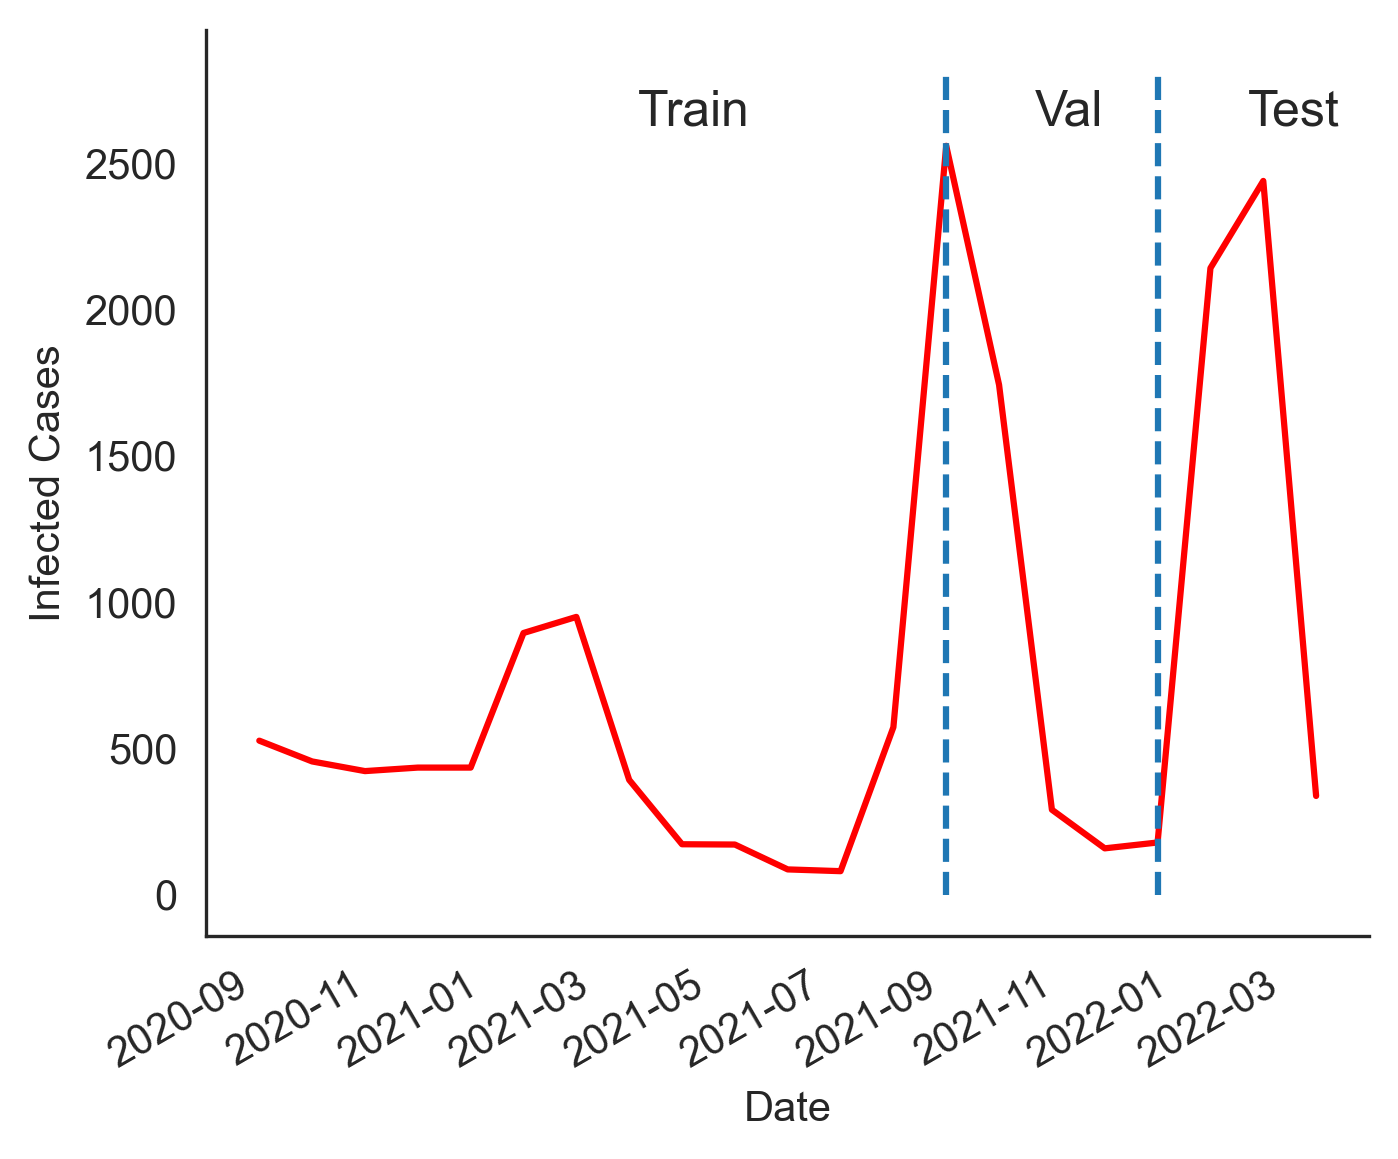

In [29]:
tmp_x = np.concatenate([train_x, val_x, test_x], axis=1)

import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd

date_idx = np.expand_dims(date_range, axis=0)
date_idx = np.expand_dims(date_idx, axis=2)
date_idx, _ = generate_series(date_idx, np.random.randn(346,21), window_size=35, pred_size=28, date=True)
date_idx = date_idx.squeeze()

sns.set_style("white")
f, axs = plt.subplots(1, 1, figsize=(5, 4), dpi=300)
sns.despine()
pal = (sns.color_palette("hls", 7))
pal[0] = (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)
index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in date_idx]
fontsize = 12

axs.plot(index, tmp_x[35, :, 0], label='Ground Truth', c='red')
cur_max = max(tmp_x[35, :, 0].max(),tmp_x[35, :, 0].max())

axs.vlines(index[-4], 0, cur_max*1.1, linestyles='dashed')
axs.vlines(index[-8], 0, cur_max*1.1, linestyles='dashed')

axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
for label in axs.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.xlabel('Date')
plt.ylabel('Infected Cases')
f.text(0.45, 0.8, 'Train', transform=f.transFigure, horizontalalignment='center', fontsize=fontsize)
f.text(0.70, 0.8, 'Val', transform=f.transFigure, horizontalalignment='center', fontsize=fontsize)
f.text(0.85, 0.8, 'Test', transform=f.transFigure, horizontalalignment='center', fontsize=fontsize)

plt.savefig('./fig/example_case.png')
#plt.legend()


In [5]:
mae_ = []
mae_exp = []
mse_ = []
mse_exp = []
r2_ = []
r2_exp = []
ccc_ = []
ccc_exp = []
for k in range(5):
    seed_torch(k)
    model = HOIST_nolstm(42, [4,5,5], 128, device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss(reduction='none')

    epoch = 300
    batch_size = 128
    min_loss = 1e99
    min_epoch = 0

    for i in range(epoch):
        epoch_loss = []
        val_loss = []
        model.train()
        for j in range((len(test_x)//batch_size)+1):
            batch_x = train_x[j*batch_size:(j+1)*batch_size]
            batch_y = train_y[j*batch_size:(j+1)*batch_size]
            batch_x = torch.tensor(batch_x).float().to(device)
            batch_y = torch.tensor(batch_y).float().to(device).unsqueeze(-1)
            batch_static = torch.tensor(static[j*batch_size:(j+1)*batch_size]).float().to(device)
            batch_mob = torch.tensor(norm_mob[j*batch_size:(j+1)*batch_size,:][:,j*batch_size:(j+1)*batch_size]).float().to(device)
            batch_dist = torch.tensor(norm_dist[j*batch_size:(j+1)*batch_size,:][:,j*batch_size:(j+1)*batch_size]).float().to(device)
            batch_mat = torch.cat([batch_mob.unsqueeze(-1), batch_dist.unsqueeze(-1)], dim=2)
            cur_static = [batch_static[:, :4], batch_static[:, 4:9], batch_static[:, 9:14], batch_mat]
            
            optimizer.zero_grad()
            output, _ = model(batch_x, cur_static)
            
            N, T, F = batch_y.shape
            dist = _[0]
            weights = _[1]
            y_p = (weights * batch_x).sum(-1).reshape(N,T,1)*output.detach()
            y_pi = y_p.reshape(N,1,T)
            y_pj = y_p.reshape(1,N,T)
            y_k = ((y_pi * y_pj) * dist.reshape(N,N,1)).sum(1).reshape(N,T,1)
            ising_loss = loss_fn(y_p+y_k, batch_y).mean(1).mean()
            
            loss = loss_fn(output, batch_y).mean(1).mean() + ising_loss
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
        
        model.eval()
        y_pred = []
        y_true = []
        with torch.no_grad():
            for j in range((len(test_x)//batch_size)+1):
                batch_x = val_x[j*batch_size:(j+1)*batch_size]
                batch_y = val_y[j*batch_size:(j+1)*batch_size]
                batch_x = torch.tensor(batch_x).float().to(device)
                batch_y = torch.tensor(batch_y).float().to(device).unsqueeze(-1)
                batch_static = torch.tensor(static[j*batch_size:(j+1)*batch_size]).float().to(device)
                batch_mob = torch.tensor(norm_mob[j*batch_size:(j+1)*batch_size,:][:,j*batch_size:(j+1)*batch_size]).float().to(device)
                batch_dist = torch.tensor(norm_dist[j*batch_size:(j+1)*batch_size,:][:,j*batch_size:(j+1)*batch_size]).float().to(device)
                batch_mat = torch.cat([batch_mob.unsqueeze(-1), batch_dist.unsqueeze(-1)], dim=2)
                cur_static = [batch_static[:, :4], batch_static[:, 4:9], batch_static[:, 9:14], batch_mat]
                
                output, _ = model(batch_x, cur_static)
                loss = loss_fn(output, batch_y).mean(1).mean()
                y_pred += list(output.squeeze().cpu().detach().numpy())
                y_true += list(batch_y.squeeze().cpu().detach().numpy())
                val_loss.append(loss.item())
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)
        norm_pred = (y_pred * normalize_dict['y'][1]) + normalize_dict['y'][0]
        norm_true = (y_true * normalize_dict['y'][1]) + normalize_dict['y'][0]
        
        cur_mse = mse(norm_true, norm_pred)
        cur_mae = mae(norm_true, norm_pred)
        if i % 100 == 0:
            print('Epoch: %d, Train Loss: %.4f, Val Loss: %.4f, MSE: %.2f, MAE: %.2f'%(i, np.mean(epoch_loss), np.mean(val_loss), cur_mse, cur_mae))
        if cur_mae < min_loss:
            min_loss = cur_mae
            min_epoch = i
            torch.save(model.state_dict(), './model/hoist_%d.pth'%k)
            
    y_pred = []
    y_true = []
    weight_score = []
    batch_size = 128
    #Load state dict
    model.load_state_dict(torch.load('./model/hoist_%d.pth'%k))
    model.eval()

    for j in range((len(test_x)//batch_size)+1):
        batch_x = test_x[j*batch_size:(j+1)*batch_size]
        batch_y = test_y[j*batch_size:(j+1)*batch_size]
        batch_x = torch.tensor(batch_x).float().to(device)
        batch_y = torch.tensor(batch_y).float().to(device).unsqueeze(-1)
        batch_static = torch.tensor(static[j*batch_size:(j+1)*batch_size]).float().to(device)
        batch_mob = torch.tensor(norm_mob[j*batch_size:(j+1)*batch_size,:][:,j*batch_size:(j+1)*batch_size]).float().to(device)
        batch_dist = torch.tensor(norm_dist[j*batch_size:(j+1)*batch_size,:][:,j*batch_size:(j+1)*batch_size]).float().to(device)
        batch_mat = torch.cat([batch_mob.unsqueeze(-1), batch_dist.unsqueeze(-1)], dim=2)
        cur_static = [batch_static[:, :4], batch_static[:, 4:9], batch_static[:, 9:14], batch_mat]
        output, _ = model(batch_x, cur_static)
        
        y_pred += list(output.squeeze().cpu().detach().numpy())
        y_true += list(batch_y.squeeze().cpu().detach().numpy())
        weight_score += list(_[1].squeeze().cpu().detach().numpy())
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    weight_score = np.array(weight_score)


    norm_pred = (y_pred * normalize_dict['y'][1]) + normalize_dict['y'][0]
    norm_true = (y_true * normalize_dict['y'][1]) + normalize_dict['y'][0]
    
    print('Best Epoch: %d, Test MSE: %.2f, MAE: %.2f, R2: %.2f, CCC: %.2f'%(min_epoch, mse(norm_true, norm_pred), mae(norm_true, norm_pred), r2(norm_true, norm_pred), ccc(norm_true, norm_pred)))
    mae_.append(mae(norm_true, norm_pred))
    mae_exp.append(mae(np.exp(norm_true), np.exp(norm_pred)))
    mse_.append(mse(norm_true, norm_pred))
    mse_exp.append(mse(np.exp(norm_true), np.exp(norm_pred)))
    r2_.append(r2(norm_true, norm_pred))
    r2_exp.append(r2(np.exp(norm_true), np.exp(norm_pred)))
    ccc_.append(ccc(norm_true, norm_pred))
    ccc_exp.append(ccc(np.exp(norm_true), np.exp(norm_pred)))

Epoch: 0, Train Loss: 2.4893, Val Loss: 3.2777, MSE: 22.30, MAE: 3.48
Epoch: 100, Train Loss: 0.6828, Val Loss: 0.1121, MSE: 0.76, MAE: 0.63
Epoch: 200, Train Loss: 0.6608, Val Loss: 0.0850, MSE: 0.58, MAE: 0.55
Best Epoch: 298, Test MSE: 0.70, MAE: 0.62, R2: 0.90, CCC: 0.95
Epoch: 0, Train Loss: 2.1303, Val Loss: 2.1597, MSE: 14.70, MAE: 2.95
Epoch: 100, Train Loss: 0.6919, Val Loss: 0.1126, MSE: 0.77, MAE: 0.65
Epoch: 200, Train Loss: 0.6676, Val Loss: 0.0914, MSE: 0.62, MAE: 0.58
Best Epoch: 288, Test MSE: 0.71, MAE: 0.64, R2: 0.90, CCC: 0.95
Epoch: 0, Train Loss: 2.1840, Val Loss: 2.9089, MSE: 19.79, MAE: 3.44
Epoch: 100, Train Loss: 0.6794, Val Loss: 0.1090, MSE: 0.74, MAE: 0.62
Epoch: 200, Train Loss: 0.6677, Val Loss: 0.0960, MSE: 0.65, MAE: 0.60
Best Epoch: 271, Test MSE: 0.67, MAE: 0.62, R2: 0.90, CCC: 0.96
Epoch: 0, Train Loss: 2.0748, Val Loss: 1.3518, MSE: 9.20, MAE: 2.40
Epoch: 100, Train Loss: 0.6877, Val Loss: 0.1226, MSE: 0.83, MAE: 0.65
Epoch: 200, Train Loss: 0.6588, 

In [7]:
print(np.mean(mse_), np.std(mse_))
print(np.mean(mse_exp), np.std(mse_exp))
print(np.mean(mae_), np.std(mae_))
print(np.mean(mae_exp), np.std(mae_exp))
print(np.mean(r2_), np.std(r2_))
print(np.mean(r2_exp), np.std(r2_exp))
print(np.mean(ccc_), np.std(ccc_))
print(np.mean(ccc_exp), np.std(ccc_exp))

0.6785942 0.046414033
3845885.5 1018530.6
0.61343527 0.015049482
368.71564 18.651665
0.9020033568009819 0.006827888284309612
0.601323965382852 0.1561582756512731
0.9537044447544132 0.0037559978775672602
0.8909342147884629 0.01898510652806212
